# Base
Como inicio dos trabalhos estabelecemos aqui o primeiro sistema para inferência do destaque territorial, 
neste caso estamos utilizando os arquivos 
- `app/input/base/ambiental_1000m.tif`
- `app/input/base/estrategico_1000m.tif`
- `app/input/base/socioeconomico_1000m.tif`

São arquivos que contem somente uma camada,  com resolução de 1000m por ponto.

### Paralelismo
Este código paraleliza e utiliza todos os CPUs disponíveis para sua execução, sendo limitada à própria máquina execução local, não sendo código distribuído (futuro).

## Como rodar
1. clone o repositório `git clone git@github.com:yurisa2/destark.git`
2. instale as dependencias `pip install -r requirements.txt` (recomendo usar o virtual environment para tal)
3. Baixe os arquivos referenciads em `app/input/base/*_1000m.tif`
4. Execute todas as células (o processamento pode durar em torno de 10 minutos com 8 CPU)

# Célula 1: Importando as Bibliotecas Necessárias


In [2]:
import rasterio  # Biblioteca para leitura e manipulação de arquivos raster (.tif).
import matplotlib.pyplot as plt  # Biblioteca para visualização e criação de gráficos.
import pandas as pd  # Biblioteca para manipulação de dados em formato de tabelas (DataFrames).
import skfuzzy as fuzz  # Biblioteca para implementação de lógica fuzzy.
from skfuzzy import (
    control as ctrl,
)  # Ferramenta da SciKit-Fuzzy para criar sistemas de controle fuzzy.
import numpy as np  # Biblioteca para operações numéricas e manipulação de arrays.
from tqdm import tqdm  # Biblioteca para criar barras de progresso durante loops.
from joblib import (
    Parallel,
    delayed,
)  # Ferramentas para paralelização de tarefas, útil para processamento em lote.

## Carregando as Bandas Raster

Cada arquivo .tif correspondente a diferentes critérios (ambiental, estratégico e socioeconômico) é carregado usando o rasterio. Esses arquivos contêm dados geoespaciais em formato raster, e apenas a primeira banda de cada arquivo é lida e armazenada em variáveis separadas.

In [3]:
ambiental_band = rasterio.open("files/input/base/ambiental_1000m.tif").read()[0]
estrategico_band = rasterio.open("files/input/base/estrategico_1000m.tif").read()[0]
socioeconomico_band = rasterio.open("files/input/base/socioeconomico_1000m.tif").read()[0]

# Verificações iniciais e definições
O código realiza uma verificação para garantir que as três bandas raster (ambiental, estratégico e socioeconômico) têm as mesmas dimensões. Isso é feito com um `assert`, que confirma que a forma (`shape`) das três bandas é idêntica. Caso as dimensões não sejam iguais, o código irá gerar um erro e interromper a execução.

Em seguida, são definidos os intervalos de valores para as coordenadas `x_n` e `y_n` com base nas dimensões das bandas raster. `x_n` corresponde ao número de linhas (eixo vertical), enquanto `y_n` corresponde ao número de colunas (eixo horizontal) da matriz que compõe cada banda raster. Isso será útil para iterar sobre os pixels das imagens posteriormente.

In [4]:
assert ambiental_band.shape == estrategico_band.shape == socioeconomico_band.shape

x_n = range(ambiental_band.shape[0])
y_n = range(ambiental_band.shape[1])

# Visualização da Entrada
Nesta célula, o código cria uma figura com três subplots para visualizar as bandas raster (ambiental, estratégico e socioeconômico). Cada banda é exibida lado a lado usando a paleta de cores rosa (cmap="pink"), com títulos específicos para cada subplot, facilitando a comparação visual entre os dados.

Text(0.5, 1.0, 'Socioeconomico Band')

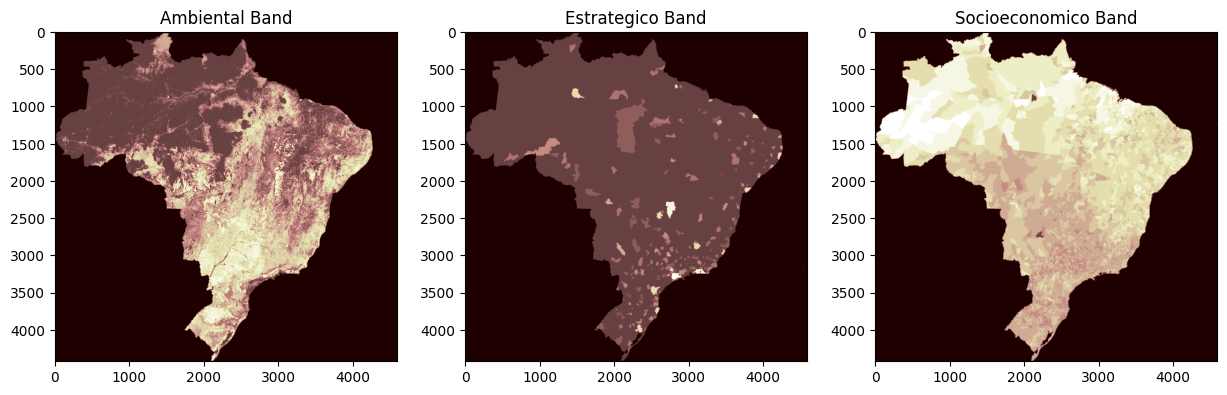

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(ambiental_band, cmap="pink")
axes[0].set_title("Ambiental Band")

axes[1].imshow(estrategico_band, cmap="pink")
axes[1].set_title("Estrategico Band")

axes[2].imshow(socioeconomico_band, cmap="pink")
axes[2].set_title("Socioeconomico Band")

# Antecedentes e consequentes
Criamos variáveis fuzzy para o sistema de lógica fuzzy: ambiental, socioeconomico e estrategico como antecedentes, e saida como consequente, todos variando de 0 a 10. Essas variáveis serão usadas para definir as regras e calcular os resultados do sistema fuzzy.

In [6]:
ambiental = ctrl.Antecedent(np.arange(0, 11, 1), "ambiental")
socioeconomico = ctrl.Antecedent(np.arange(0, 11, 1), "socioeconomico")
estrategico = ctrl.Antecedent(np.arange(0, 11, 1), "estrategico")
saida = ctrl.Consequent(np.arange(0, 11, 1), "saida")

# Funções de pertencimento
O código define funções de pertencimento fuzzy para a variável `ambiental` e visualiza essas funções:

1. **Definição das Funções de Pertencimento**:
   - `ambiental["baixo"] = fuzz.trapmf(ambiental.universe, [0, 0, 2, 4])`: Cria uma função de pertencimento trapezoidal chamada "baixo" para a variável `ambiental`, com valores de 0 a 4. O grau de pertencimento é 1 entre 0 e 2 e decresce para 0 entre 2 e 4.
   - `ambiental["medio"] = fuzz.trapmf(ambiental.universe, [2, 4, 6, 7])`: Define a função de pertencimento "medio", com valores de 2 a 7. O grau de pertencimento é 1 entre 4 e 6 e varia de 0 a 1 nos extremos.
   - `ambiental["alto"] = fuzz.trapmf(ambiental.universe, [6, 7, 10, 10])`: Estabelece a função de pertencimento "alto", com valores de 6 a 10. O grau de pertencimento é 1 entre 7 e 10 e decresce para 0 fora desse intervalo.

2. **Visualização das Funções de Pertencimento**:
   - `ambiental.view()`: Exibe um gráfico das funções de pertencimento definidas para a variável `ambiental`, mostrando como os diferentes níveis (baixo, médio, alto) são representados.

### Para as outras variaveis de entrada (socioeconomico e estratégico ) o mesmo procedimento será feito

/Users/yurisa2/personal/destark/.venv/lib/python3.11/site-packages/skfuzzy/control/fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


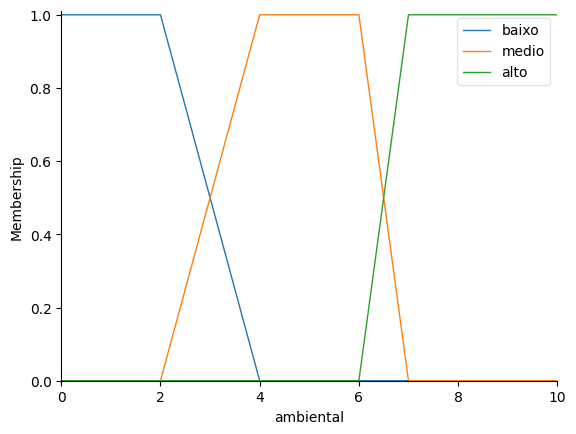

In [7]:
ambiental["baixo"] = fuzz.trapmf(ambiental.universe, [0, 0, 2, 4])
ambiental["medio"] = fuzz.trapmf(ambiental.universe, [2, 4, 6, 7])
ambiental["alto"] = fuzz.trapmf(ambiental.universe, [6, 7, 10, 10])
ambiental.view()

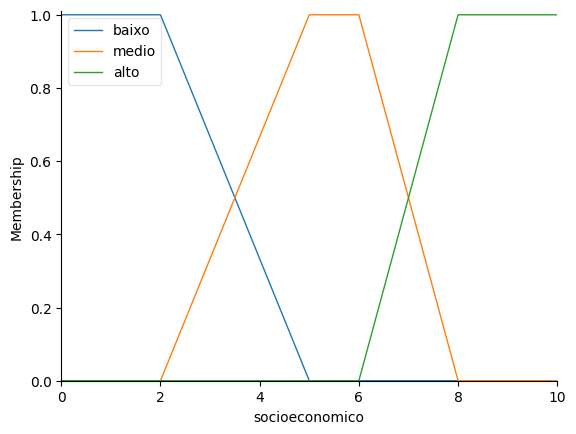

In [8]:
socioeconomico["baixo"] = fuzz.trapmf(socioeconomico.universe, [0, 0, 2, 5])
socioeconomico["medio"] = fuzz.trapmf(socioeconomico.universe, [2, 5, 6, 8])
socioeconomico["alto"] = fuzz.trapmf(socioeconomico.universe, [6, 8, 10, 10])
socioeconomico.view()

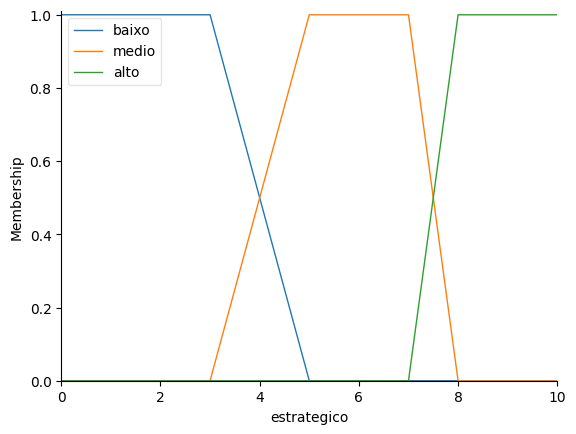

In [9]:
estrategico["baixo"] = fuzz.trapmf(estrategico.universe, [0, 0, 3, 5])
estrategico["medio"] = fuzz.trapmf(estrategico.universe, [3, 5, 7, 8])
estrategico["alto"] = fuzz.trapmf(estrategico.universe, [7, 8, 10, 10])
estrategico.view()

# Definição da variável de saída
O código define funções de pertencimento fuzzy para a variável `saida` e visualiza essas funções:

**Definição das Funções de Pertencimento**:
   - `saida["MBx"] = fuzz.trimf(saida.universe, [0, 0, 2.5])`: Cria uma função de pertencimento triangular chamada "MBx" para a variável `saida`, com valores de 0 a 2.5. O grau de pertencimento é 1 no valor 0 e diminui até 0 em 2.5.
   - `saida["BX"] = fuzz.trimf(saida.universe, [0, 2.5, 5])`: Define a função de pertencimento "BX", variando de 0 a 5. O grau de pertencimento é 1 no ponto 2.5 e decresce para 0 em 0 e 5.
   - `saida["Med"] = fuzz.trimf(saida.universe, [2.5, 5, 7.5])`: Estabelece a função de pertencimento "Med", com valores de 2.5 a 7.5. O grau de pertencimento é 1 no valor 5 e decresce para 0 em 2.5 e 7.5.
   - `saida["A"] = fuzz.trimf(saida.universe, [5, 5.5, 10])`: Define a função de pertencimento "A", variando de 5 a 10. O grau de pertencimento é 1 no ponto 5.5 e diminui para 0 em 5 e 10.
   - `saida["MA"] = fuzz.trimf(saida.universe, [7.5, 10, 10])`: Cria a função de pertencimento "MA", com valores de 7.5 a 10. O grau de pertencimento é 1 no ponto 10 e diminui para 0 em 7.5.

In [10]:
saida["MBx"] = fuzz.trimf(saida.universe, [0, 0, 2.5])
saida["BX"] = fuzz.trimf(saida.universe, [0, 2.5, 5])
saida["Med"] = fuzz.trimf(saida.universe, [2.5, 5, 7.5])
saida["A"] = fuzz.trimf(saida.universe, [5, 5.5, 10])
saida["MA"] = fuzz.trimf(saida.universe, [7.5, 10, 10])

# Criação das regras
O código define um conjunto de 27 regras para o sistema fuzzy, associando combinações de condições das variáveis de entrada (`ambiental`, `socioeconomico`, `estrategico`) com diferentes valores de saída (`saida`). As saídas representam níveis de intensidade:

- **"MBx"**: Muito Baixo
- **"BX"**: Baixo
- **"Med"**: Médio
- **"A"**: Alto
- **"MA"**: Muito Alto

As regras especificam como diferentes combinações de entrada afetam a saída, variando entre esses níveis de intensidade.

In [11]:
# regras
regra1 = ctrl.Rule(
    ambiental["baixo"] & socioeconomico["baixo"] & estrategico["alto"], saida["MBx"]
)
regra2 = ctrl.Rule(
    ambiental["baixo"] & socioeconomico["baixo"] & estrategico["medio"], saida["MBx"]
)
regra3 = ctrl.Rule(
    ambiental["baixo"] & socioeconomico["baixo"] & estrategico["baixo"], saida["MBx"]
)
regra4 = ctrl.Rule(
    ambiental["baixo"] & socioeconomico["medio"] & estrategico["alto"], saida["Med"]
)
regra5 = ctrl.Rule(
    ambiental["baixo"] & socioeconomico["medio"] & estrategico["medio"], saida["Med"]
)
regra6 = ctrl.Rule(
    ambiental["baixo"] & socioeconomico["medio"] & estrategico["baixo"], saida["Med"]
)
regra7 = ctrl.Rule(
    ambiental["baixo"] & socioeconomico["alto"] & estrategico["alto"], saida["BX"]
)
regra8 = ctrl.Rule(
    ambiental["baixo"] & socioeconomico["alto"] & estrategico["medio"], saida["Med"]
)
regra9 = ctrl.Rule(
    ambiental["baixo"] & socioeconomico["alto"] & estrategico["baixo"], saida["A"]
)
regra10 = ctrl.Rule(
    ambiental["medio"] & socioeconomico["baixo"] & estrategico["alto"], saida["BX"]
)
regra11 = ctrl.Rule(
    ambiental["medio"] & socioeconomico["baixo"] & estrategico["medio"], saida["Med"]
)
regra12 = ctrl.Rule(
    ambiental["medio"] & socioeconomico["baixo"] & estrategico["baixo"], saida["Med"]
)
regra13 = ctrl.Rule(
    ambiental["medio"] & socioeconomico["medio"] & estrategico["alto"], saida["BX"]
)
regra14 = ctrl.Rule(
    ambiental["medio"] & socioeconomico["medio"] & estrategico["medio"], saida["Med"]
)
regra15 = ctrl.Rule(
    ambiental["medio"] & socioeconomico["medio"] & estrategico["baixo"], saida["Med"]
)
regra16 = ctrl.Rule(
    ambiental["medio"] & socioeconomico["alto"] & estrategico["alto"], saida["Med"]
)
regra17 = ctrl.Rule(
    ambiental["medio"] & socioeconomico["alto"] & estrategico["medio"], saida["Med"]
)
regra18 = ctrl.Rule(
    ambiental["medio"] & socioeconomico["alto"] & estrategico["baixo"], saida["A"]
)
regra19 = ctrl.Rule(
    ambiental["alto"] & socioeconomico["baixo"] & estrategico["alto"], saida["BX"]
)
regra20 = ctrl.Rule(
    ambiental["alto"] & socioeconomico["baixo"] & estrategico["medio"], saida["A"]
)
regra21 = ctrl.Rule(
    ambiental["alto"] & socioeconomico["baixo"] & estrategico["baixo"], saida["A"]
)
regra22 = ctrl.Rule(
    ambiental["alto"] & socioeconomico["medio"] & estrategico["alto"], saida["Med"]
)
regra23 = ctrl.Rule(
    ambiental["alto"] & socioeconomico["medio"] & estrategico["medio"], saida["A"]
)
regra24 = ctrl.Rule(
    ambiental["alto"] & socioeconomico["medio"] & estrategico["baixo"], saida["MA"]
)
regra25 = ctrl.Rule(
    ambiental["alto"] & socioeconomico["alto"] & estrategico["alto"], saida["MA"]
)
regra26 = ctrl.Rule(
    ambiental["alto"] & socioeconomico["alto"] & estrategico["medio"], saida["MA"]
)
regra27 = ctrl.Rule(
    ambiental["alto"] & socioeconomico["alto"] & estrategico["baixo"], saida["MA"]
)

# Definição do sistema de controle e simulação (cálculo das entradas)
Cria uma simulação do sistema de controle fuzzy chamada `destaque` usando o sistema de controle `destaque_ctrl`. Isso permite aplicar as regras definidas e calcular as saídas com base nas entradas fornecidas.

In [12]:
destaque_ctrl = ctrl.ControlSystem(
    [
        regra1,
        regra2,
        regra3,
        regra4,
        regra5,
        regra6,
        regra7,
        regra8,
        regra9,
        regra10,
        regra11,
        regra12,
        regra13,
        regra14,
        regra15,
        regra16,
        regra17,
        regra18,
        regra19,
        regra20,
        regra21,
        regra22,
        regra23,
        regra24,
        regra25,
        regra26,
        regra27,
    ]
)
destaque = ctrl.ControlSystemSimulation(destaque_ctrl)

# Processamento e resultado
Cria uma matriz `output_matrix` preenchida com zeros, com as mesmas dimensões que a banda ambiental. Em seguida, define a função `process_pixel(i, j)` para processar cada pixel da imagem:

1. **Definição da Função `process_pixel`**:
   - A função recebe as coordenadas do pixel `(i, j)`.
   - Atribui os valores das bandas de entrada (`ambiental_band`, `socioeconomico_band`, `estrategico_band`) ao sistema de controle fuzzy `destaque` para o pixel específico.
   - Calcula a saída do sistema fuzzy com `destaque.compute()`.
   - Armazena o valor da saída na `output_matrix` para o pixel correspondente.

Essa função será usada para aplicar o sistema de controle fuzzy a cada pixel da imagem raster.

2. **Matrix result**:
Cria uma matriz result preenchida com zeros, com as mesmas dimensões que a banda ambiental. Isso é utilizado para armazenar os resultados da aplicação do sistema de controle fuzzy a cada pixel da imagem raster.

In [13]:
output_matrix = np.zeros(ambiental_band.shape)

## Execução paralelizada
Executa o processamento paralelo para aplicar a função `process_pixel` a cada pixel da imagem raster:

1. **Processamento Paralelo**:
   - Utiliza `Parallel` e `delayed` da biblioteca `joblib` para paralelizar a execução da função `process_pixel` para cada coordenada `(i, j)`.
   - `n_jobs=-1` indica que todos os núcleos de CPU disponíveis serão usados.
   - `tqdm(x_n)` fornece uma barra de progresso para monitorar o avanço do processamento.

2. **Atribuição dos Resultados**:
   - Itera sobre `parallel_results`, que contém os resultados de `process_pixel` para cada pixel.
   - Atribui cada valor calculado à posição correspondente na matriz `result`.

Isso acelera o processamento ao distribuir a carga entre múltiplos núcleos de CPU e organiza os resultados na matriz final.

In [14]:
# Ensure this function is defined at the top level
def process_pixel(i, j):
    destaque.input["ambiental"] = ambiental_band[i, j]
    destaque.input["socioeconomico"] = socioeconomico_band[i, j]
    destaque.input["estrategico"] = estrategico_band[i, j]
    destaque.compute()
    return (i, j, destaque.output["saida"])


result = np.zeros(ambiental_band.shape)

# Parallel processing
parallel_results = Parallel(n_jobs=-1)(
    delayed(process_pixel)(i, j) for i in tqdm(x_n) for j in y_n
)

# Assign the results to the result array
for i, j, value in parallel_results:
    result[i, j] = value

100%|██████████| 20319432/20319432 [00:05<00:00, 3444819.23it/s]


# Verificação do resultado
Exibe a matriz `result` como uma imagem usando a paleta de cores rosa (`cmap='pink'`). Adiciona uma barra de cores para referência e define o título da imagem como "Result Map". A função `plt.show()` exibe a imagem gerada, permitindo a visualização dos resultados do processamento fuzzy.

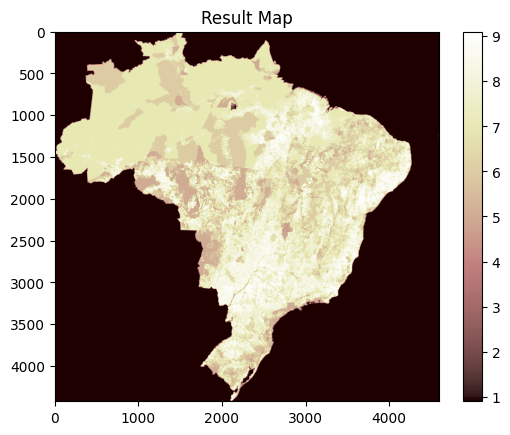

In [15]:
plt.imshow(result, cmap='pink')
plt.colorbar()
plt.title('Result Map')
plt.show()

# Escreve o Arquivo TIFF

Define o caminho do arquivo de saída e cria um novo arquivo raster para salvar o resultado:

1. **Definição do Caminho do Arquivo**:
   - `output_file = "files/output/result.tif"`: Define o caminho e o nome do arquivo onde o resultado será salvo.

2. **Criação e Escrita no Arquivo Raster**:
   - Abre um novo arquivo raster com o driver 'GTiff' (GeoTIFF), especificando o caminho do arquivo, o tamanho da imagem (`height` e `width`), o número de bandas (`count=1`), e o tipo de dados (`dtype`).
   - Usa o contexto `with` para garantir que o arquivo seja corretamente fechado após a operação.
   - Escreve a matriz `result` na primeira banda do arquivo raster.

Isso salva a matriz `result` em um arquivo raster no formato GeoTIFF para posterior uso e análise.

In [16]:
# Define the output file path
output_file = "files/output/base/result.tif"

# Create a new raster file for writing
with rasterio.open(output_file, 'w', driver='GTiff', height=result.shape[0], width=result.shape[1], count=1, dtype=result.dtype) as dst:
    # Write the result array to the raster file
    dst.write(result, 1)

/Users/yurisa2/personal/destark/.venv/lib/python3.11/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(
